# Using a fNN to predict Dota 2 teams victory probability

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import itertools

import pickle
import gzip

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer

from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.layers import Dense, Dropout, GRU
from tensorflow.keras.optimizers import Adam

from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix

In [3]:
# importing the cleaned match data
match_df = pd.read_csv("../data/complete_match_df.csv")

rad_cvec = CountVectorizer()
dire_cvec = CountVectorizer()
rad_df = pd.DataFrame(rad_cvec.fit_transform(match_df['radiant']).toarray() , columns = rad_cvec.get_feature_names())
dire_df = pd.DataFrame(dire_cvec.fit_transform(match_df['dire']).toarray() , columns = dire_cvec.get_feature_names())
match_hero_df = pd.concat([rad_df,dire_df], axis=1)

X = match_hero_df
y = match_df['winner'].map({'radiant' : 1 , 'dire' : 0})

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=2020)

#Calculating the baseline accuracy of the data
y_test.value_counts(normalize=True)

1    0.569456
0    0.430544
Name: winner, dtype: float64

In [6]:
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

### Feed forward NN

In [18]:
model_fNN = Sequential()

model_fNN.add(Dense(238, activation='relu', input_shape=(X_train.shape[1],)))
model_fNN.add(Dropout(0.85))

model_fNN.add(Dense(512, activation='relu'))
model_fNN.add(Dropout(0.85))

model_fNN.add(Dense(32, activation='relu'))
model_fNN.add(Dropout(0.1))

model_fNN.add(Dense(1, activation='sigmoid'))

model_fNN.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

history_fNN = model_fNN.fit(X_train_sc, y_train, epochs=50,batch_size=1024,validation_data=(X_test_sc, y_test))

Train on 67554 samples, validate on 22518 samples
Epoch 1/50
67554/67554 [==============================] - 5s 71us/sample - loss: 0.8545 - acc: 0.5181 - val_loss: 0.6917 - val_acc: 0.5693
Epoch 2/50
67554/67554 [==============================] - 5s 68us/sample - loss: 0.7024 - acc: 0.5420 - val_loss: 0.6901 - val_acc: 0.5695
Epoch 3/50
67554/67554 [==============================] - 5s 68us/sample - loss: 0.6919 - acc: 0.5574 - val_loss: 0.6885 - val_acc: 0.5695
Epoch 4/50
67554/67554 [==============================] - 5s 69us/sample - loss: 0.6873 - acc: 0.5670 - val_loss: 0.6870 - val_acc: 0.5695
Epoch 5/50
67554/67554 [==============================] - 5s 70us/sample - loss: 0.6864 - acc: 0.5683 - val_loss: 0.6869 - val_acc: 0.5695
Epoch 6/50
67554/67554 [==============================] - 5s 70us/sample - loss: 0.6847 - acc: 0.5698 - val_loss: 0.6857 - val_acc: 0.5695
Epoch 7/50
67554/67554 [==============================] - 5s 71us/sample - loss: 0.6840 - acc: 0.5720 - val_loss: 0.

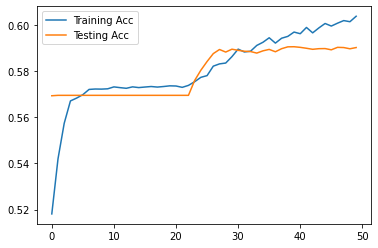

In [19]:
plt.plot(history_fNN.history['acc'], label="Training Acc")
plt.plot(history_fNN.history['val_acc'], label="Testing Acc")
plt.legend();

0.593 accuracy is the best accuracy (about 2.5% better accuracy from the uneven baseline)

In [20]:
#saving the NN to be used as a hero recommender
model_fNN.save("../data/NN_model/NN_model")

In [9]:
NN_preds = model_fNN.predict_classes(X_test)

In [19]:
# found plot confusion matrix function at https://deeplizard.com/learn/video/km7pxKy4UHU
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 8698   997]
 [10394  2429]]


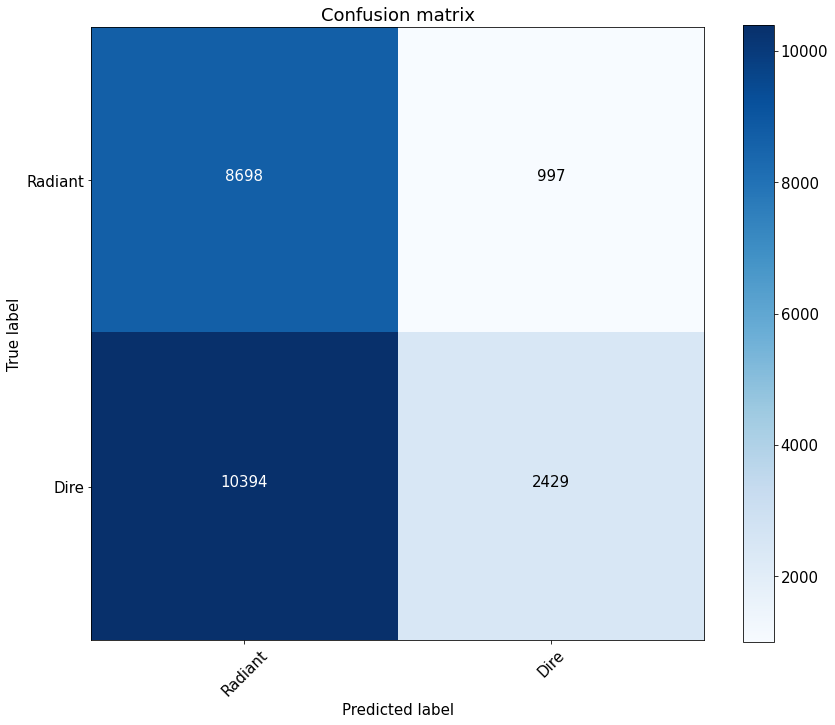

In [20]:
#generate confusion matrix values from Naive Bayes
cm = confusion_matrix(y_test,NN_preds)
plt.figure(figsize=(12,10))
plt.rcParams.update({'font.size': 15})
plot_confusion_matrix(cm=cm, classes=["Radiant","Dire"]);

As expected the NN model predicts radiant a very large percentage of the time.

More data is need to provide more information to better predict Dire wins